<a href="https://colab.research.google.com/github/20KMJ/ESAA7/blob/main/0310.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAPTER3 분류

## 3.1 MNIST

In [1]:
# MNIST 데이터셋 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# 데이터셋 배열 살펴보기
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


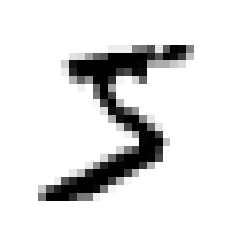

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 특성 벡터 추출 후 28*28 배열로 크기 바꾸기
some_digit = X[:1]
some_digit_image = some_digit.to_numpy().reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

In [4]:
import numpy as np
y = y.astype(np.uint8)

In [5]:
# 데이터 분할
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

In [6]:
# 5는 True고, 다른 숫자는 모두 False
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
# SGDClassifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
nx, ny = some_digit.shape
some_digit_array = some_digit.to_numpy().reshape(nx*ny)

sgd_clf.predict([some_digit_array])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [ ]:
# 교차 검증 직접 구현
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.loc[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train.loc[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [ ]:
# cross_val_score()
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
# 모두 '5 아님'으로 분류
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [ ]:
# 정확도 확인
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 이미지의 10% 정도만 숫자 5이기 때문에 이런 결과가 나왔음
- 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌
- 특히 **불균형한 데이터셋**을 다룰 때 더욱 그럼

### 3.3.2 오차 행렬

- 분류기 성능 평가에 좋은 방법인 오차 행렬(confusion matrix)

In [ ]:
# 예측값 생성
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- cross_val_predict() 함수: k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 **예측을 반환**함

In [ ]:
# 오차 행렬 생성
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- '5 아님'으로 정확하게 분류: 53892
- '5'라고 잘못 분류: 687

- '5'로 정확하게 분류: 3530
- '5 아님'으로 잘못 분류: 1891

In [ ]:
# 완벽한 분류기일 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- **정밀도(precision)**: 양성 예측의 정확도

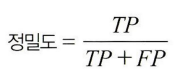

- **재현율(recall)**: 분류기가 정확하게 감지한 양성 샘플의 비율. 민감도 또는 TPR이라고도 함

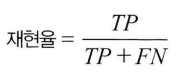

### 3.3.3 정밀도와 재현율

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))  # 정밀도
print(recall_score(y_train_5, y_train_pred))  # 재현율

0.8370879772350012
0.6511713705958311


- 5로 판별된 이미지 중 83.7%만 정확함
- 전체 숫자 5에서 65%만 감지했음

- 정밀도와 재현율을 F1 score라고 하는 하나의 숫자로 만들면 편리함. 특히 두 분류기를 비교할 때 편리.
- F1 score는 정밀도와 재현율의 **조화 평균**

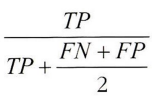

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- 정밀도와 재현율이 비슷한 분류기에서는 F1 score가 높음

- 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중효할 수도 있음
- 예를 들어 어린아이에게 **나쁜 동영상을 걸러내는 분류기**를 훈련시키는 경우. 재현율은 높은 것보다 **정밀도**가 높은 분류기를 더 선호(좋은 동영상이 많이 제외되더라도 안전한 것들만 노출시키는 분류기)


- 감시 카메라를 통해 좀도둑을 잡아내는 분류기의 경우, 재현율이 99%라면 정확도가 30%만 되더라도 괜찮을지 모름. (경비원이 잘못된 호출을 종종 받게 되겠지만, 거의 모든 좀도둑을 잡을 것임)

### 3.3.4 정밀도/재현율 트레이드오프

- 임곗값이 높을수록 재현율은 낮아지고 반대로 (보통) 정밀도는 높아짐

In [ ]:
y_scores = sgd_clf.decision_function([some_digit_array])
y_scores

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [ ]:
# 임곗값 0
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
# 임곗값 8000
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 임곗값을 높이면 재현율이 줄어드는 것을 보여줌 (임곗값이 0일 때는 분류기가 이를 감지했지만, 임곗값을 8000으로 높이면 이를 놓치게 됨)

In [ ]:
# 예측 결과가 아니라 결정 점수를 반환받도록 지정
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

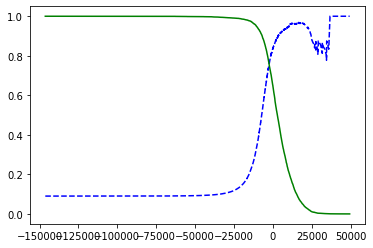

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
  [...] # 임곗값 표시하고 범례, 축 이름, 그리드 추가

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- 정밀도 곡선(blue)이 울퉁불퉁한 이유: 임곗값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문.(일반적으로는 높아져야 하지만)

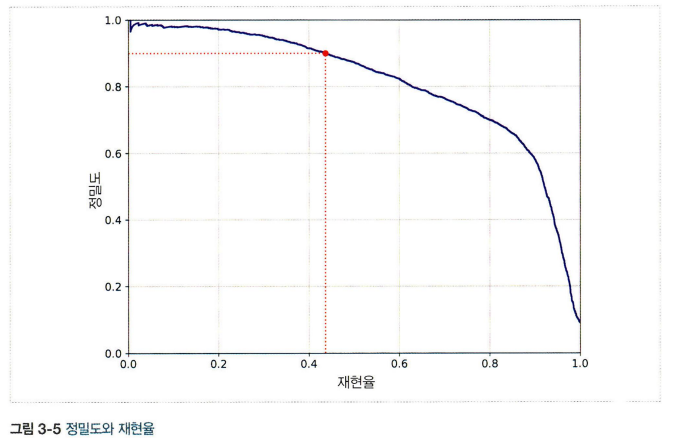

- 좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법 [그림 3-5]
- 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작함
- 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음 (여기선 재현율이 60% 정도인 지점)

In [ ]:
# 최소한 90% 정밀도가 되는 가장 낮은 임곗값
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

- `np.argmax()`: 최댓값의 첫 번째 인덱스 반환 (여기에선 첫 번째 True 값 의미)

In [ ]:
# 훈련 세트에 대한 예측
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
# 위 예측에 대한 정밀도와 재현율
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### 3.3.5 ROC 곡선

- 수신기 조작 특성 곡선 (ROC 곡선)
- 이진 분류에서 널리 사용
- 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선
- 민감도(재현율)에 대한 1-특이도 그래프

In [ ]:
# 여러 임곗값에서 TPR과 FPR을 계산
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

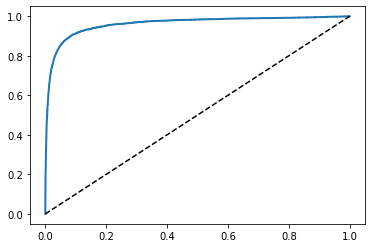

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') # 대각 점선
  [...] # 축 이름, 그리드 추가

plot_roc_curve(fpr, tpr)
plt.show()

- 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야 함(왼쪽 위 모서리)
- 곡선 아래의 면적(AUC)을 측정하면 분류기들을 비교할 수 있음

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> TIP (ROC 곡선 vs 정밀도/재현율(PR) 곡선)
> - PR 곡선: 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 사용
> - 그렇지 않으면 ROC 곡선을 사용용

- 위의 ROC 곡선을 보면 매우 좋은 분류기라고 생각할 수 있으나 이는 음성(5 아님)에 비해 양성(5)이 크게 적기 때문
- 이와 다르게 PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는지 잘 보여줌

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

- `predict_proba()`: 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환함 (예를 들어 어떤 이미지가 5일 확률 70%)

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

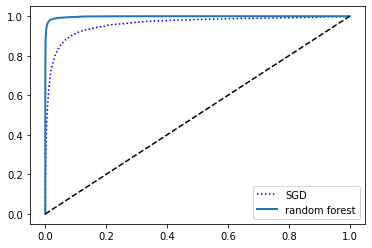

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random forest")
plt.legend(loc="lower right")
plt.show()

- 비교를 위해 첫 번째 ROC 곡선도 함께 그림
- 여기선 랜덤 포레스트 분류기가 SGD 분류기보다 훨씬 좋음

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

> summary
> - 이진 분류기를 훈련시키는 방법
> - 작업에 맞는 적절한 지표 선택
> - 교차 검증을 사용한 평가
> - 요구 사항에 맞는 정밀도/재현율 트레이드오프 선택
> - ROC 곡선과 ROC AUC 점수를 사용한 여러 모델의 비교

## 3.4 다중 분류

- 이진 분류: 두 개의 클래스를 구별
- 다중 분류(다항 분류): 둘 이상의 클래스를 구별

- SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 등등 : 여러 개의 클래스를 직접 처리 가능
- 로지스틱 회귀, 서포트 벡터 머신 분류 : 이진 분류만 가능 (하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 있음-> OvR(OvA)전략, OvO 전략)

- MNIST 문제에서는 45개의 분류기를 훈련시켜야 함.
- 이미지 하나를 분류하려면 45개 분류기 모두를 통과시켜서 가장 많이 양성으로 분류된 클래스를 선택

- OvO 전략의 장점: 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요
- 서포트 벡터 머신 같은 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호함
- 하지만 대부분 이진 분류알고리즘에서 OvR을 선호

In [ ]:
# 서포트 벡터 머신 분류기
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train을 사용함
svm_clf.predict([some_digit_array])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [ ]:
# 가장 높은 점수가 클래스 5에 해당하는 값
some_digit_scores = svm_clf.decision_function([some_digit_array])
some_digit_scores

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

In [ ]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기 만들기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit_array])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [9]:
# SGDClassifier 훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit_array])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [10]:
# 클래스별 점수 확인
sgd_clf.decision_function([some_digit_array])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

- 대부분의 점수가 큰 음수: 분류기가 예측 결과에 강한 확신을 보이고 있음을 알 수 있음

In [15]:
# 분류기 평가: 교차 검증
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [17]:
# 정확도 향상시키기 (입력 스케일링 조정)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

In [19]:
# 오차 행렬
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

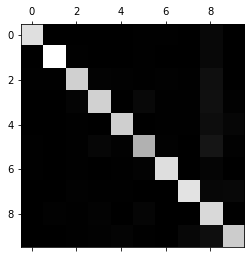

In [20]:
# 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 **주대각선**에 있으므로 매우 좋아 보임.
- 숫자 5는 다른 숫자보다 조금 더 어두워 보임. 이는 데이터셋의 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻.

In [24]:
# 에러 비율 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

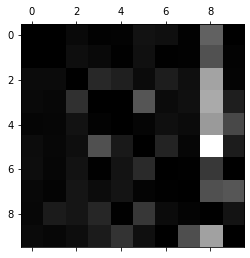

In [22]:
# 주대각선 0
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 클래스 8의 **열**(세로)이 상당히 밝음 -> 많은 이미지가 8로 잘못 분류되었음을 암시함 -> 개선 필요함 (실제 8은 아니지만 8처럼 보이는 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기 학습시키기, 동심원의 수 세는 알고리즘(8은 2개, 6은 1개, 5는 0개) 등)
- 클래스 8의 **행**(가로): 나쁘지 않음 -> 실제 8이 적절히 8로 분류되었음
- 3과 5가 서로 많이 혼동되고 있음

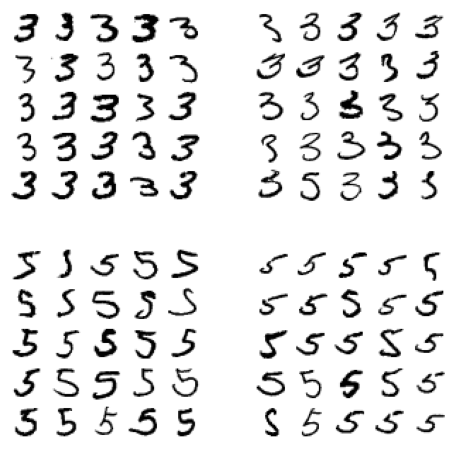

In [28]:
# 3, 5 샘플 그리기
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 왼쪽 블록 두 개는 3으로 분류된 이미지
- 오른쪽 블록 두 개는 5로 분류된 이미지

- SGDClassifier는 선형 모델. 선형 분류기는 단순히 픽셀 강도의 가중치 합을 클래스 점수로 계산함. 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동함
- 3과 5의 에러를 줄이는 방법: 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 하기

## 3.6 다중 레이블 분류

- 분류기가 샘플마다 **여러 개의 클래스를 출력**해야 하는 경우: 얼굴 인식 분류기에서 같은 사진에 여러 사람이 등장하는 경우 -> **다중 레이블 분류** 시스템

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit_array])

In [ ]:
# 다중 레이블 분류기 평가
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

- 위의 경우는 모든 레이블의 가중치가 같다고 가정한 경우.
- 그러나 예를 들어 앨리스 사진이 밥이나 찰리 사진보다 훨씬 많다면 앨리스 사진에 대한 분류기의 점수에 더 높은 가중치를 둬야 함. 간단한 방법은 레이블에 클래스의 **지지도를 가중치로 주는 것**.(지지도는 타깃 레이블에 속한 샘플 수). -> `average="weighted"`

## 3.7 다중 출력 분류


- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것.(즉, 값을 두 개 이상 가질 수 있음)

> 잡음을 제거하는 시스템을 만들어보자.  
> 잡음이 많은 숫자 이미지 -> 깨끗한 숫자 이미지로

In [29]:
# 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


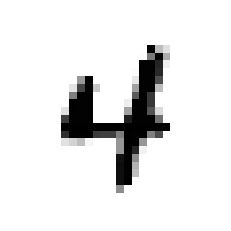

In [68]:
from sklearn.neighbors import KNeighborsClassifier

some_index = 95
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

plot_digit(clean_digit)